# This notebook looks at +/- 30mm SWE retrieval error for 0.6m snowpack
## Compares results for -10dB and -13dB soil contributions

SSA data from combined 2013-2018 dataset



In [1]:
# Standard imports
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
import scipy.io as sio

/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Import layer SSA median info
layer_stats = pd.read_excel('../2013_2018_combined_data/2013_2018_layer_stats.xls', sheet_name='Sheet1', index_col=0).T
ssa_med = np.asarray(layer_stats.SSA_median)
# Pull in all SSA data - used in histogram
ssa = sio.loadmat('../2013_2018_combined_data/TVC2013_2018_SSA.mat',struct_as_record=False, squeeze_me=True)

# Code to run spatial variability simulations for the TVC paper

 - 3-layer simulations
 - spatial variability in SSA in a single layer (either FS-fresh snow, WS-wind slab or DH-depth hoar)
 - all other properties have mean value attributed to them
 - density / SSA data from combined 2013-2018 dataset
 - layer thickness vs snow depth from 2013 dataset only


In [3]:
# Define default values
density_med = np.asarray(layer_stats.density_median)
fixed_temperature = 265 # Assumption: not based on data
# Ingest spatial variability info
# Transpose to make it easier to index
hist_bins = pd.read_excel('../2013_2018_combined_data/2013_2018_hist_edge_stats.xls', header=None, index_col=0).T
hist_freq = pd.read_excel('../2013_2018_combined_data/2013_2018_hist_frequency_stats.xls', header=None, index_col=0).T
# Transpose layer_stats so can grab all layers together

# Function to calculate bin midpoint from histogram edges
# Call with e.g. calc_bin_mid(hist_bins['Histogram bin edges FS'])
def calc_bin_mid(layer):
    bin_width = layer[2]-layer[1]
    return np.asarray(layer[0:-1] + bin_width / 2.)

In [16]:
# Make a function to calc swe
def calc_swe(depth_array, layer_densities, thickness_lookup):
    swe = []
    for depth in depth_array:
        layer_thickness = np.asarray(thickness_lookup[np.around(depth,3)]).flatten()
        swe.append(np.sum(layer_thickness*layer_densities))
    return np.asarray(swe)

### Set up layer thickness by depth

Assumptions based on 2013 trench data only


In [44]:
# Fix depth range between 0.5 and 0.7m
depths = np.arange(0.4, 0.8, 0.005)
thickness_pc_fs = -44.7269 * depths + 30.1551
thickness_pc_ws = 31.8305 * depths + 47.8097
# DH percent thickness treated as constant (it hardly varies)
thickness_pc_dh = np.ones([depths.size]) * 29.6 # Actual eqn is 1.4821 * depths + 29.0613
# Make FS% zero if < 0
thickness_pc_fs[thickness_pc_fs < 0] = 0
# Derive WS thickness from DH and FS
thickness_pc_ws = 100 - thickness_pc_fs - thickness_pc_dh
thickness = np.column_stack((np.multiply(thickness_pc_fs, depths), np.multiply(thickness_pc_ws, depths), np.multiply(thickness_pc_dh, depths)))
thickness = thickness * 1e-2 # % percent converted to fraction of 1

### Set up smrt configuration

For now just use single SMRT config: EXP-IBA


In [45]:
# SMRT imports
from smrt import make_snowpack, make_model, sensor
from smrt.substrate.reflector_backscatter import make_reflector
from smrt.core.globalconstants import DENSITY_OF_ICE, FREEZING_POINT
from smrt.utils import dB, invdB

# Make model
imodel = make_model("iba","dort")

# Make sensor
scatt = sensor.active([13.4e9, 17.2e9], 35)

# Make a substrate
# 0.05 = -13dB
sub13 = make_reflector(temperature=265, specular_reflection=0.,
                           backscattering_coefficient={'VV': 0.05, 'HH': 0.05})
# 0.1 = -10dB
sub10 = make_reflector(temperature=265, specular_reflection=0.,
                           backscattering_coefficient={'VV': 0.1, 'HH': 0.1})

## Layer spatial variability

### Function to calculate 'Truth' simulations

In [46]:
def forward_simulation(lay, sub, bins=hist_bins, ssa=ssa_med, density=density_med, 
                       temperature=fixed_temperature, depths=depths, thickness=thickness):
    # Construct truth pex array
    truth_pex = []
    for sp in range(5):
        ssa_var = deepcopy(ssa) # Need to leave original ssa intact
        if lay == 0:
            ssa_var[lay] = calc_bin_mid(hist_bins['Histogram bin edges FS'])[sp]
        elif lay == 1:
            ssa_var[lay] = calc_bin_mid(hist_bins['Histogram bin edges WS'])[sp]
        elif lay == 2:
            ssa_var[lay] = calc_bin_mid(hist_bins['Histogram bin edges DH'])[sp]
        else:
            print ('layer not known')
        truth_pex.append(0.75 * (4.*(1.0-density/DENSITY_OF_ICE)/(ssa_var*DENSITY_OF_ICE)))
        
    # Construct list of snowpacks
    snowpack0 = []
    snowpack1 = []
    snowpack2 = []
    snowpack3 = []
    snowpack4 = []

    for d in range(len(depths)):
        firstlay = 1 # Default top layer is WS unless
        if thickness[d,0] > 0: # First column is FS
            firstlay = 0 # Include FS layer
        snowpack0.append(make_snowpack(thickness=thickness[d, firstlay:3], microstructure_model="exponential", 
                                       density=density[firstlay:3],temperature=fixed_temperature, 
                                       corr_length=truth_pex[0][firstlay:3], substrate=sub))
        snowpack1.append(make_snowpack(thickness=thickness[d, firstlay:3], microstructure_model="exponential", 
                                       density=density[firstlay:3],temperature=fixed_temperature, 
                                       corr_length=truth_pex[1][firstlay:3], substrate=sub))
        snowpack2.append(make_snowpack(thickness=thickness[d, firstlay:3], microstructure_model="exponential", 
                                       density=density[firstlay:3],temperature=fixed_temperature, 
                                       corr_length=truth_pex[2][firstlay:3], substrate=sub))
        snowpack3.append(make_snowpack(thickness=thickness[d, firstlay:3], microstructure_model="exponential", 
                                       density=density[firstlay:3],temperature=fixed_temperature, 
                                       corr_length=truth_pex[3][firstlay:3], substrate=sub))
        snowpack4.append(make_snowpack(thickness=thickness[d, firstlay:3], microstructure_model="exponential", 
                                       density=density[firstlay:3],temperature=fixed_temperature, 
                                       corr_length=truth_pex[4][firstlay:3], substrate=sub))
        
    # Calc SWE
    SWE_truth_mm = [ np.sum(1000*thickness[d]*(density/1000)) for d in range(len(depths))]

    # Run simulations
    res0 = imodel.run(scatt, snowpack0, snowpack_dimension=('swe', SWE_truth_mm))
    res1 = imodel.run(scatt, snowpack1, snowpack_dimension=('swe', SWE_truth_mm))
    res2 = imodel.run(scatt, snowpack2, snowpack_dimension=('swe', SWE_truth_mm))
    res3 = imodel.run(scatt, snowpack3, snowpack_dimension=('swe', SWE_truth_mm))
    res4 = imodel.run(scatt, snowpack4, snowpack_dimension=('swe', SWE_truth_mm))
    
    # Calc layer spatial variable weightings i.e. convert to fractional
    if lay == 2:
        weights = np.asarray(hist_freq['Histogram bin frequency DH']) / np.sum(hist_freq['Histogram bin frequency DH'])
    elif lay == 1:
        weights = np.asarray(hist_freq['Histogram bin frequency WS']) / np.sum(hist_freq['Histogram bin frequency WS'])
    elif lay == 0:
        weights = np.asarray(hist_freq['Histogram bin frequency FS']) / np.sum(hist_freq['Histogram bin frequency FS'])
    else:
        print ('layer not known')
        
    # Aggregate results:
    # Weighted scene
    sigmaVV_agg = (weights[0] * res0.sigmaVV()+ weights[1] * res1.sigmaVV() + weights[2] * res2.sigmaVV()
                   + weights[3] * res3.sigmaVV() + weights[4] * res4.sigmaVV())

    # 17-13 sigmaVV difference
    sigma_truth_diff = sigmaVV_agg.sel(frequency=17.2e9)-sigmaVV_agg.sel(frequency=13.4e9)
    return(sigma_truth_diff)

## Homogeneous retrieval snowpack

### Function to retrieve SWE from backscatter difference
3-layer retrieval so 'perfect' retrieval theoretically possible.

In [47]:
def retrieval(lay, sub, sigma_truth_diff, ssa=ssa_med, density=density_med, 
                       temperature=fixed_temperature, depths=depths, thickness=thickness):
    # create the errors. SSA ± 50% out
    #SSArange = np.arange(0.6,1.42,0.02) * ssa[lay]
    SSArange = np.arange(0.85,1.0,0.02) * ssa[lay]
    pex_range =  np.array([0.75 * (4.*(1.0-(density/DENSITY_OF_ICE))/(ssa*DENSITY_OF_ICE))]*len(SSArange))    
    pex_range.T[lay] = 0.75 * (4.*(1.0-(density[lay]/DENSITY_OF_ICE))/(SSArange*DENSITY_OF_ICE))
    
    # Create unknown snowpacks. Loop 1: Depth, Loop 2 p_ex_error. Density fixed
    # i.e. depth held constant (slow loop) whilst p_ex changed (fast loop)
    # depth is increasing, pex decreasing
    # Snow layers in TVC_trenches are numbered from the top as 1=Fresh Snow, 2=Wind Slab, 3=Depth Hoar
    # SMRT layers are numbered from 1 = top also.
    # Need to have 3 layers unless no fresh snow
    snowpacks_pexerr = []
    for s in range(len(depths)):
        for p in range(len(pex_range)):
            firstlay = 1 # Default top layer is WS unless
            if thickness[s,0] > 0: # First column is FS
                firstlay = 0 # Include FS layer 
            snowpack = make_snowpack(thickness[s, firstlay:3], 
                                "exponential",
                                density=density[firstlay:3],
                                corr_length=pex_range[p][firstlay:3],
                                temperature=fixed_temperature,
                                substrate=sub)
            snowpacks_pexerr.append(snowpack)
            
    # Get results out for simulated snowpacks
    res_pexerr = imodel.run(scatt, snowpacks_pexerr)
    sigma_diff_pexerr = res_pexerr.sigmaVV(frequency=17.2e9) - res_pexerr.sigmaVV(frequency=13.4e9)
    # Reshape results
    sigma_diff_pexerr_reshape = (np.reshape(sigma_diff_pexerr.data,(len(depths), len(pex_range))))
    
    # Do depth retrieval
    # Don't see loop over retrieved snow depth: Depth information included in sigma_diff arrays
    # Sigma_truth_diff is the aggregated backscatter
    ret_depth = np.empty([len(depths), len(pex_range)])
    for true_depth in range(len(depths)):
        for p in range(len(pex_range)):
            CF_td = np.square(sigma_diff_pexerr_reshape[:,p] - sigma_truth_diff.values[true_depth])
            #if np.around(depths[true_depth],1) == 0.7:
            #    print (sigma_diff_pexerr_reshape[:,p], sigma_truth_diff.values[true_depth])
            # Find depth index with minimum CF for a given microstructure
            d_index = np.where(CF_td == np.min(CF_td))[0] # [0] accesses index
            ret_depth[true_depth, p] = depths[d_index]
            
    # create dictionary #Change 
    thickness_lookup = dict(zip(np.around(depths,3), zip(thickness)))

    # Calc SWE retrieval error #LEANNE ADDED swe_calc and swe_truth
    swe_ERROR = []
    for p in range(len(pex_range)):
        swe_ERROR.append(calc_swe(ret_depth[:,p],density,thickness_lookup) - calc_swe(depths,density,thickness_lookup))
    # Turn into array for plotting, and transpose for plotting
    swe_ERROR = np.asarray(swe_ERROR).T
    return (SSArange, swe_ERROR)


In [48]:
# Calc DH spatial variability effect
# Have to tell it which substrate using
dh_truth_10 = forward_simulation(2, sub10)
dh_ssa_10, dh_swe_ret_10 = retrieval(2, sub10, dh_truth_10)

active model is not yet fully implemented, need modification for the third component


In [49]:
dh_truth_13 = forward_simulation(2, sub13)
dh_ssa_13, dh_swe_ret_13 = retrieval(2, sub13, dh_truth_13)

active model is not yet fully implemented, need modification for the third component


In [52]:
depths[40]

0.6000000000000002

In [53]:
dh_swe_ret_10[40]

array([-65.57950593, -56.22578711, -41.87543949, -25.480563  ,
        -5.18138444,  17.57920752,  41.34709816,  62.13917016])

In [54]:
dh_swe_ret_13[40]

array([-51.48497382, -41.87543949, -28.79743689, -15.41624556,
        -1.73186547,  14.02546743,  32.43621016,  47.28769016])

In [55]:
ssa_percent = np.arange(0.85,1.0,0.02)

<IPython.core.display.Javascript object>


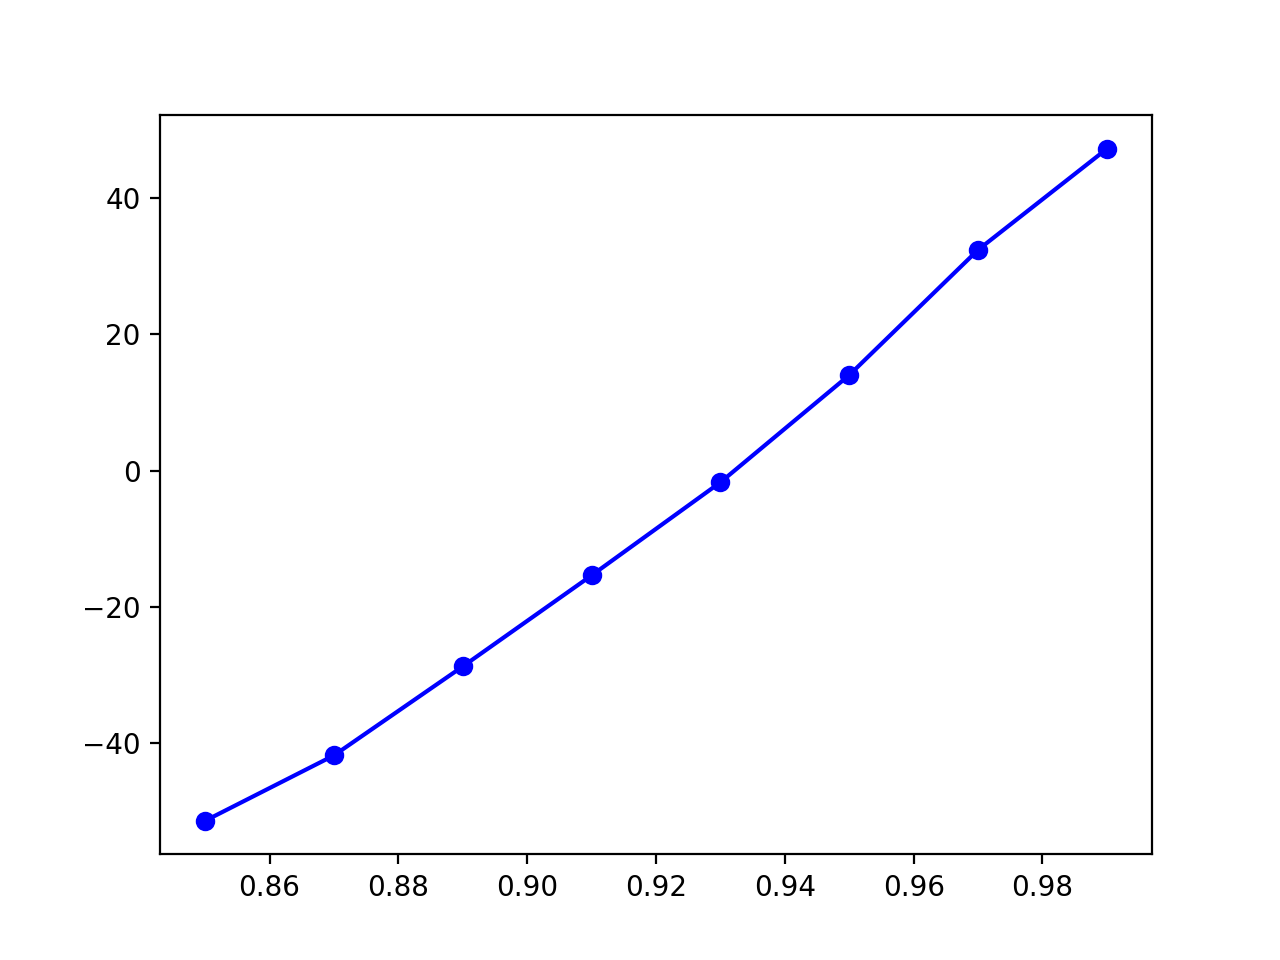

In [56]:
# Make function to determine what the SSA would be at -30mm SWE retrieval error
plt.plot(ssa_percent, dh_swe_ret_13[40], 'bo-')

In [57]:
# Numpy interpolated ssa percent at 30mm SWE error limits
# Graph is linear away from retrieval limits: linear interpolation best
np.interp([-30, 30],dh_swe_ret_13[40],ssa_percent)

array([0.88816094, 0.96735349])

In [58]:
# Graph is linear away from retrieval limits: linear interpolation best
np.interp([-30, 30],dh_swe_ret_10[40],ssa_percent)

array([0.90448677, 0.96045174])